<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Libraries,-functions-and-CPW-params" data-toc-modified-id="Libraries,-functions-and-CPW-params-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Libraries, functions and CPW params</a></span></li><li><span><a href="#Cavity-response" data-toc-modified-id="Cavity-response-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Cavity response</a></span></li><li><span><a href="#Pump-powers" data-toc-modified-id="Pump-powers-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Pump powers</a></span></li><li><span><a href="#The-full-loop" data-toc-modified-id="The-full-loop-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>The full loop</a></span></li></ul></div>

This is the notebook for the shunt bias cavity with a Josephson junction array, only this time we evaluate the response for a series of unit cell lengths

# Libraries, functions and CPW params

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.interpolate import interp1d
import time
import os
import pandas as pd
import stlabutils

import sys
from src.model_currentbias import lossrate

from scipy.constants import hbar, e, h, Planck, c

Phi0 = Planck/(2*e)
pi = np.pi
c0 = c

In [2]:
lcD = pickle.load(open('data_processed/JJarrayCPW_analytical_1um_pars.pkl','rb'))
lcD.keys()

dict_keys(['l', 'N', 'I', 'Anh', 'f0'])

In [3]:
currs = lcD['I']
f0 = lcD['f0']
l = lcD['l']
N = lcD['N']
Anh = lcD['Anh']

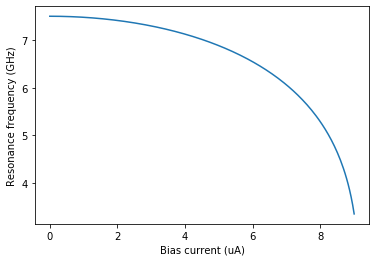

In [4]:
plt.plot(currs/1e-6,f0/1e9)
plt.xlabel('Bias current (uA)')
plt.ylabel('Resonance frequency (GHz)')

pickle.dump({'xopt':currs/1e-6,'yopt':f0/1e9},open('data_final/JJarrayCPW_analytical_1um_f0vI.pkl','wb'))

# Cavity response

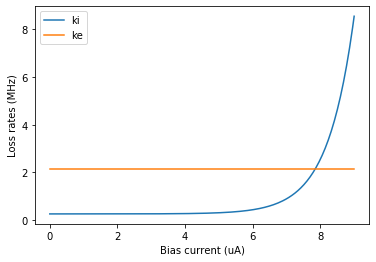

In [5]:
# we use the exponential fit from investigating_lossrates.ipynb
# assume constant loss rates as a function of power
# assume constant external loss rate

lossratedict = pickle.load(
    open('data_processed/sensitivity_estimation/lossrate_expfit.pkl', 'rb'))
kint = lossrate(
    currs, lossratedict['ki0 (Hz)'], lossratedict['kialpha (Hz)'], lossratedict['kiix (A)'])
kext = lossrate(
    currs, lossratedict['ke0 (Hz)'], lossratedict['kealpha (Hz)'], lossratedict['keix (A)'])
kext = np.array([lossratedict['ke0 (Hz)']]*len(kint))*4 # constant external loss rate
ktot = kint+kext

plt.plot(currs/1e-6,kint/1e6,label='ki')
plt.plot(currs/1e-6,kext/1e6,label='ke')
plt.ylabel('Loss rates (MHz)')
plt.xlabel('Bias current (uA)')
plt.legend()

# Pump powers

In [6]:
P_out_VNA = np.linspace(-20, 41, 101)  # range from experiment, +10dB extended
power_in = pickle.load(
    open("data_processed/sensitivity_estimation/power_in.pkl", "rb"))
attenuation = -power_in['P_in_sample (dBm)']
P_in_sample = P_out_VNA - attenuation
Probe_powers = P_in_sample
Probe_powers_lin = 10**(Probe_powers / 10) * 1e-3  # dBm to W

# The full loop

In [7]:
ii = np.linspace(0,9e-6,91)
ii

array([0.0e+00, 1.0e-07, 2.0e-07, 3.0e-07, 4.0e-07, 5.0e-07, 6.0e-07,
       7.0e-07, 8.0e-07, 9.0e-07, 1.0e-06, 1.1e-06, 1.2e-06, 1.3e-06,
       1.4e-06, 1.5e-06, 1.6e-06, 1.7e-06, 1.8e-06, 1.9e-06, 2.0e-06,
       2.1e-06, 2.2e-06, 2.3e-06, 2.4e-06, 2.5e-06, 2.6e-06, 2.7e-06,
       2.8e-06, 2.9e-06, 3.0e-06, 3.1e-06, 3.2e-06, 3.3e-06, 3.4e-06,
       3.5e-06, 3.6e-06, 3.7e-06, 3.8e-06, 3.9e-06, 4.0e-06, 4.1e-06,
       4.2e-06, 4.3e-06, 4.4e-06, 4.5e-06, 4.6e-06, 4.7e-06, 4.8e-06,
       4.9e-06, 5.0e-06, 5.1e-06, 5.2e-06, 5.3e-06, 5.4e-06, 5.5e-06,
       5.6e-06, 5.7e-06, 5.8e-06, 5.9e-06, 6.0e-06, 6.1e-06, 6.2e-06,
       6.3e-06, 6.4e-06, 6.5e-06, 6.6e-06, 6.7e-06, 6.8e-06, 6.9e-06,
       7.0e-06, 7.1e-06, 7.2e-06, 7.3e-06, 7.4e-06, 7.5e-06, 7.6e-06,
       7.7e-06, 7.8e-06, 7.9e-06, 8.0e-06, 8.1e-06, 8.2e-06, 8.3e-06,
       8.4e-06, 8.5e-06, 8.6e-06, 8.7e-06, 8.8e-06, 8.9e-06, 9.0e-06])

In [8]:
currlist = [int(round(x * 1e9)) for x in ii]

In [9]:
### SIMULATING THE DUFFING RESPONSE
f0theo = interp1d(currs,f0)(ii)
betaint = -interp1d(currs,Anh)(ii)

kinttheo = interp1d(currs,kint)(ii)
kexttheo = interp1d(currs,kext)(ii)
ktottheo = kinttheo+kexttheo

G1 = np.gradient(f0theo, ii)

for kk, numcurrent in enumerate(currlist):

    start_time = time.time()

    mypath = 'Duffing/'
    prefix = "JJarrayCPW"
    idstring = "{:.1f}_{:.0f}_{:04d}".format(l/1e-6,N,numcurrent)
    filepath = mypath+prefix+'_'+idstring+".dat"
    print(filepath)
    if True:
#     if not os.path.isfile(filepath):

        Probe_freqs = np.linspace(f0theo[kk] - 10e6, f0theo[kk] + 5e6, 501)
        freqlength = len(Probe_freqs)

        for i, (P_p_log, P_p_lin) in enumerate(zip(Probe_powers, Probe_powers_lin)):

            # On-chip photon flux
            n_p = P_p_lin / hbar / 2 / pi / Probe_freqs

            # Intracavity photon number
            a = 4 * pi**2 * betaint[kk]**2
            b = -2 * 2 * pi * (Probe_freqs - f0theo[kk]) * 2 * pi * betaint[kk]
            c = (2 * pi * (Probe_freqs - f0theo[kk])
                 )**2 + (2 * pi * ktottheo[kk])**2 / 4
            d = -2 * pi * kexttheo[kk] * n_p
            coeffs = [[a, x2, x3, x4]
                      for (x2, x3, x4) in zip(b, c, d)]

            allroots = [np.roots(coeff) for coeff in coeffs]
            allroots = [[i.real if i.imag == 0 else np.nan for i in roots]
                        for roots in allroots]
            alpha_0 = np.array(
                [np.nanmin(alpha) for alpha in allroots])

            # Calculate response
            Delta = Probe_freqs - f0theo[kk]
            phi = np.arctan(-2 *
                            (Delta - betaint[kk] * alpha_0) / ktottheo[kk])
            S11 = 1 - np.sqrt(2 * pi * kexttheo[kk] * alpha_0) / np.sqrt(
                n_p) * np.exp(-1j * phi)

            mydf = pd.DataFrame({
                'Probe Frequency (Hz)': Probe_freqs,
                'Probe power (W)': [P_p_lin]*freqlength,
                'Probe power (dBm)': [P_p_log]*freqlength,
                'S11dB (dB)': 20*np.log10(abs(S11)),
                'S11ph (rad)': np.angle(S11),
                'Intracavity photons ()': alpha_0,
                'Beta (Hz)': [betaint[kk]]*freqlength,
                'Delta (Hz)': Delta,
                'Phi (rad)': phi,
                'Iset (A)': ii[kk],
                'kint (Hz)': kinttheo[kk],
                'kext (Hz)': kexttheo[kk],
                'f0 (Hz)': f0theo[kk],
                'G1 (Hz/A)': G1[kk],
                'l (m)': l,
                'N ()': N
            })

            if i == 0:
                myfile = stlabutils.newfile(
                    prefix,
                    idstring,
                    mypath=mypath,
                    usedate=False,
                    usefolder=False,
                    colnames=list(mydf),
                    git_id=False)

            stlabutils.saveframe(myfile, mydf)
            stlabutils.utils.metagen.fromarrays(
                myfile,
                Probe_freqs,
                Probe_powers[0:i + 1],
                xtitle='Probe Frequency (Hz)',
                ytitle='Probe power (dBm)',
                colnames=list(mydf))

        myfile.close()
        elapsed_time = time.time() - start_time
        print('Elapsed time: {:.2f}s'.format(elapsed_time))

Duffing/JJarrayCPW_1.0_845_0000.dat
None
Duffing
Duffing/JJarrayCPW_1.0_845_0000.dat
Measurement Name:  JJarrayCPW_1.0_845_0000
metagen.fromarrays: Warning, equal values for ymin and ymax. Correcting
Elapsed time: 5.23s
Duffing/JJarrayCPW_1.0_845_0100.dat
None
Duffing
Duffing/JJarrayCPW_1.0_845_0100.dat
Measurement Name:  JJarrayCPW_1.0_845_0100
metagen.fromarrays: Warning, equal values for ymin and ymax. Correcting
Elapsed time: 5.41s
Duffing/JJarrayCPW_1.0_845_0200.dat
None
Duffing
Duffing/JJarrayCPW_1.0_845_0200.dat
Measurement Name:  JJarrayCPW_1.0_845_0200
metagen.fromarrays: Warning, equal values for ymin and ymax. Correcting
Elapsed time: 5.41s
Duffing/JJarrayCPW_1.0_845_0300.dat
None
Duffing
Duffing/JJarrayCPW_1.0_845_0300.dat
Measurement Name:  JJarrayCPW_1.0_845_0300
metagen.fromarrays: Warning, equal values for ymin and ymax. Correcting
Elapsed time: 5.31s
Duffing/JJarrayCPW_1.0_845_0400.dat
None
Duffing
Duffing/JJarrayCPW_1.0_845_0400.dat
Measurement Name:  JJarrayCPW_1.0_8